In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
train = pd.read_csv("/content/Titanic/train.csv")
test = pd.read_csv("/content/Titanic/test.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
age_pclass = train[['Age', 'Pclass']].dropna()


In [11]:
age_pclass.groupby('Pclass')['Age'].describe()


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,186.0,38.233441,14.802856,0.92,27.0,37.0,49.0,80.0
2,173.0,29.877630,14.001077,0.67,23.0,29.0,36.0,70.0
3,355.0,25.140620,12.495398,0.42,18.0,24.0,32.0,74.0


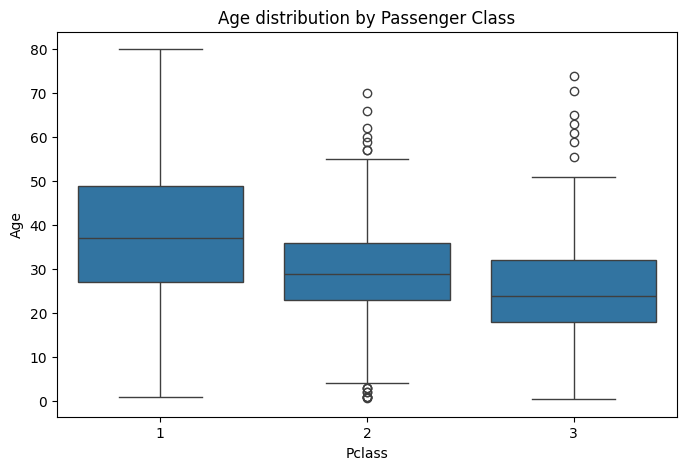

In [15]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Pclass', y='Age', data=train)
plt.title('Age distribution by Passenger Class')
plt.show()


In [18]:
age_pclass.groupby('Pclass')['Age'].median()


,Age
Pclass,
1,37.0
2,29.0
3,24.0


In [20]:
pclass_age_median = train.groupby('Pclass')['Age'].median()
print(pclass_age_median)


Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64


In [23]:
def fill_age_by_pclass(row):
    if pd.isnull(row['Age']):
        return pclass_age_median[row['Pclass']]
    return row['Age']

train['Age'] = train.apply(fill_age_by_pclass, axis=1)
test['Age'] = test.apply(fill_age_by_pclass, axis=1)


In [24]:
print(train['Age'].isnull().sum())
print(test['Age'].isnull().sum())


0
0


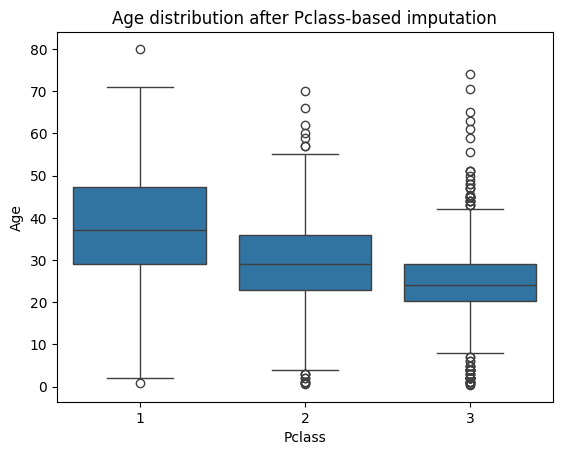

In [25]:


sns.boxplot(x='Pclass', y='Age', data=train)
plt.title('Age distribution after Pclass-based imputation')
plt.show()


In [30]:
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})


In [38]:
from sklearn.linear_model import LogisticRegression
X = train[['Age','Pclass','Sex',]]
y = train['Survived']

model = LogisticRegression(max_iter=1000)
model.fit(X, y)

print(model.score(X, y))


0.7957351290684624


In [35]:
val = train.groupby('Embarked')['Survived'].mean()
print(val)

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


In [37]:
drop_cols = ['Name','Ticket','Cabin']
train.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)


In [39]:
train.groupby(['Embarked','Pclass'])['Survived'].mean()


Embarked  Pclass
C         1         0.694118
          2         0.529412
          3         0.378788
Q         1         0.500000
          2         0.666667
          3         0.375000
S         1         0.582677
          2         0.463415
          3         0.189802
Name: Survived, dtype: float64

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42
)
rf.fit(X, y)

print("RF Accuracy:", rf.score(X, y))


RF Accuracy: 0.8787878787878788


In [45]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X, y, cv=5)
print("CV Accuracy:", scores.mean())


CV Accuracy: 0.8294080723118448


In [46]:
from sklearn.model_selection import train_test_split

X = train[['Age','Pclass','Sex',]]
y = train['Survived']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [47]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=6, n_estimators=300, random_state=42)

In [49]:
val_accuracy = rf.score(X_val, y_val)
print("Validation Accuracy:", val_accuracy)


Validation Accuracy: 0.7932960893854749


In [55]:
for df in [train, test]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1


In [56]:
for df in [train, test]:
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)


In [57]:
test['Fare'] = test['Fare'].fillna(test['Fare'].median())


In [58]:
import numpy as np

for df in [train, test]:
    df['FareLog'] = np.log1p(df['Fare'])


In [61]:
X = train[['Age','Pclass','Sex','FamilySize','IsAlone','FareLog']]
y = train['Survived']

model = LogisticRegression(max_iter=1000)
model.fit(X, y)

print("Accuracy:", model.score(X, y))


Accuracy: 0.8069584736251403


In [62]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42
)
rf.fit(X, y)

print("RF Accuracy:", rf.score(X, y))


RF Accuracy: 0.8787878787878788


In [63]:
features = ['Age','Pclass','Sex','FamilySize','IsAlone','FareLog']
X_test = test[features]



In [64]:
rf_final = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42
)

rf_final.fit(X, y)   # train on ALL labeled data


RandomForestClassifier(max_depth=6, n_estimators=300, random_state=42)

In [69]:
test_predictions = rf_final.predict(X_test)


In [68]:
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('submission2.csv', index=False)
